# Results plots

This notebook contains all the results plots using all the data extracted from the `main/pick_best_models.py` script with the `conf/tyra.yaml` configuration file. This plots will use different levels of treatment: `dnbr` and `frp` under different population of vegetation: `conifers` , `shrublands`, and `all` (removing all urban and agricultural areas). The outcomes are the following:
 - **dnbr**: The difference between the pre and post fire NBR values.
 - **frp**: The Fire Radiative Power (FRP) values.
 - **emissions**: The emissions values.

Following the `tyra` configuration, the best results and weights for each combination of treatment and vegetation type are stored in the `best_models/` folder with treatment and vegetation best weights and balancing results according with `loss` and `asmd`, our two metrics of interest during the optimization process in the `main/balancing.py`.  

In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.estimate.calculate_estimator import calculate_estimator
from prescribed.plot import (
    plot_loss_check,
    plot_outcomes,
    plot_std_diffs,
    template_plots,
)
from prescribed.utils import prepare_template

In [25]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 15

In [3]:
import os
os.listdir("../tyra/mtbs_treatments_results_inmediate")

['dnbr_treat_shrubs', 'dnbr_treatment_conifers']

In [8]:
dnbr_type = "gee_inmediate"
criteria = "asmd"  # Doesn't matter! We use loss or asmd, both have the same targets
results_dir = "../tyra/mtbs_treatments_results"

conifers_loss = {
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_std_diffs.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_std_diffs.csv"
    ),
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
}

shrubs_loss = {
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treat_shrubs/best_model_{criteria}_std_diffs.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_shrubs/best_model_{criteria}_std_diffs.csv"
    ),
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
}

# Load MTBS to give years to the DNBR data
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Load data for outcomes
template = (
    prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")
    .groupby("grid_id", as_index=False)
    .first()
    .drop(columns=["year"])
)

wide_treatments = pd.read_feather(
    f"/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_{dnbr_type}/wide_treats_mtbs.feather"
)

# Filter wide treatments to only include conifers and shrubs
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

wide_treatments_conifers = wide_treatments[
    wide_treatments.grid_id.isin(land_type[land_type.land_type == 2].grid_id.values)
]

wide_treatments_shrubs = wide_treatments[
    wide_treatments.grid_id.isin(land_type[land_type.land_type == 12].grid_id.values)
]

frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp_nominal_conf/frp_concat.feather"
)

dnbr = pd.read_feather(
    f"/mnt/sherlock/oak/prescribed_data/processed/dnbr_{dnbr_type}/dnbr_long.feather"
)

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
)

# Load template for aux plots and also emission inventories
template = (
    prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")
    .groupby("grid_id", as_index=False)
    .first()
    .drop(columns=["year"])
)

# Emissions FINN
emissions_all = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/emissions_finn/finn_GEOSCHEM_mean.feather"
)
emissions_all["year"] = emissions_all["time"].dt.year

# Load land type data and CA boundaries for aux plots
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("3310")

# Transform to a GeoDataFrame
land_type = gpd.GeoDataFrame(
    land_type,
    geometry=gpd.points_from_xy(land_type.lon, land_type.lat),
    crs="EPSG:3310",
)

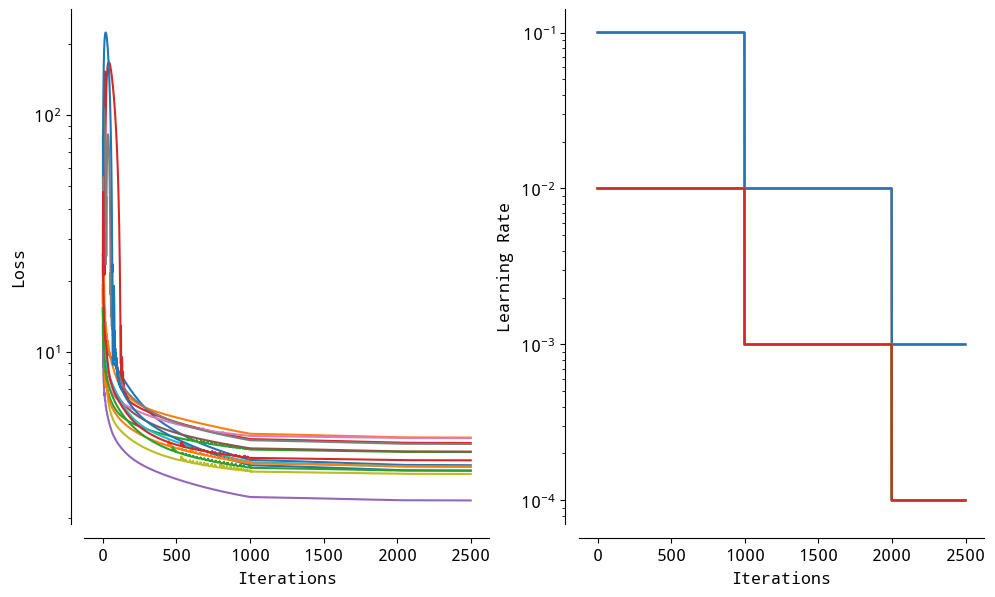

In [16]:
plot_loss_check(
    path_to_losses="/mnt/sherlock/oak/prescribed_data/results/mtbs_dnbr_inmediate_treatment_shrublands/loss",
    best_model_path="../tyra/mtbs_treatments_results_inmediate/dnbr_treat_shrubs/best_model_loss.csv",
)
plt.savefig("../figs/optimization_results.png")

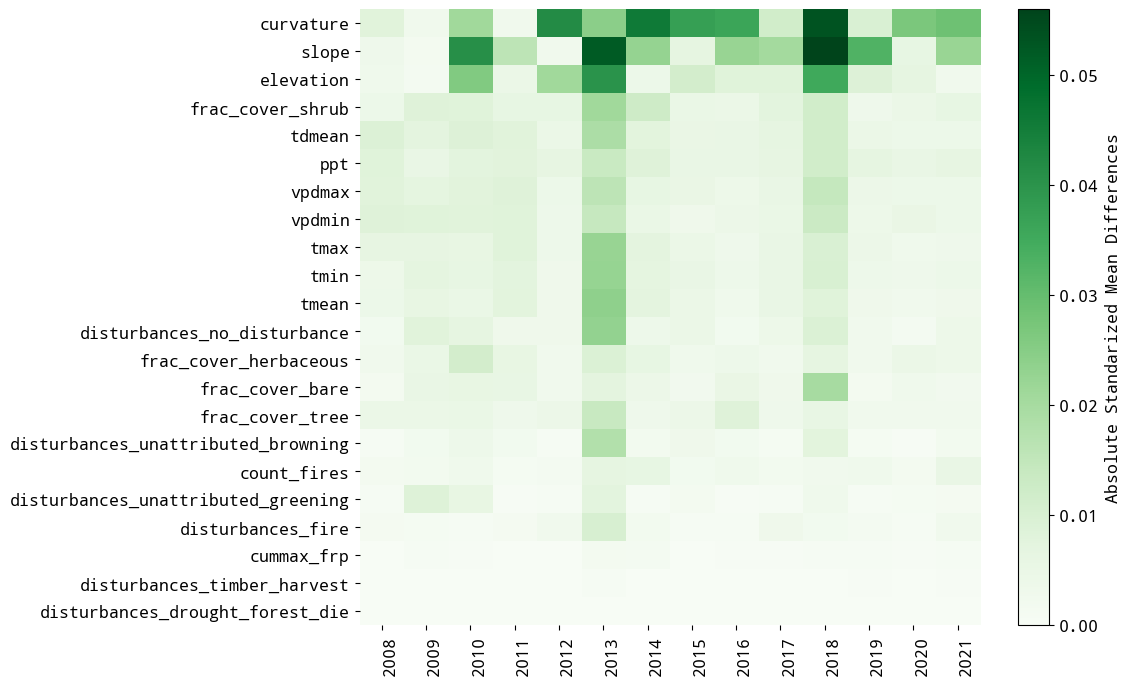

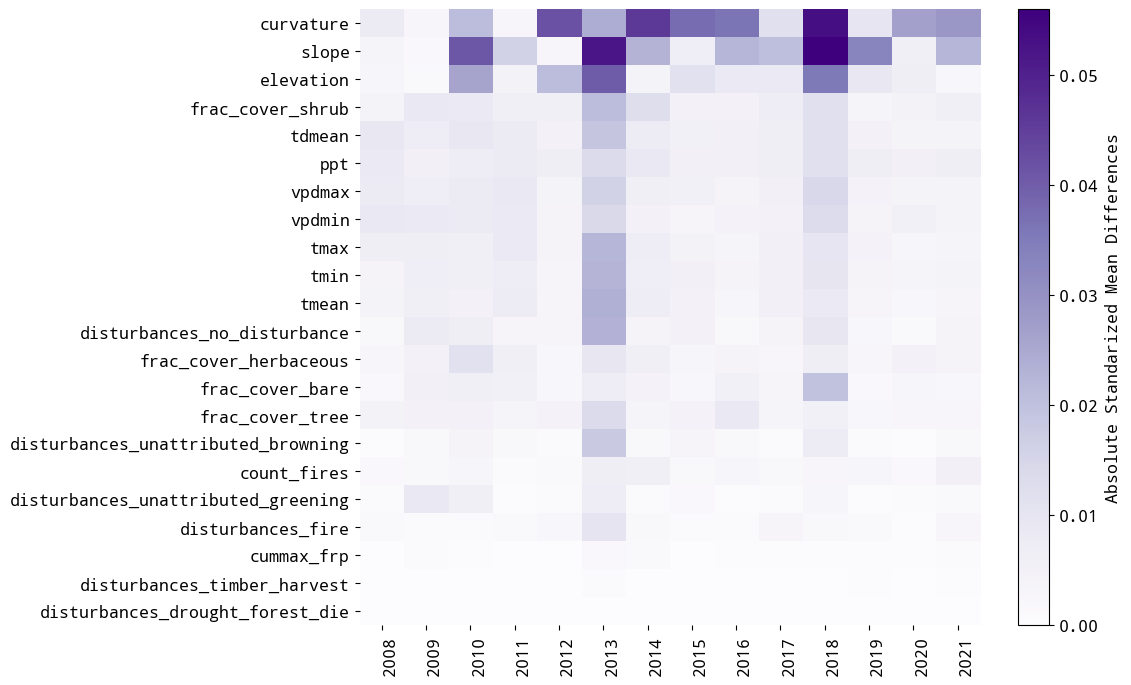

In [31]:
# Set the font size to be 12
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_std_diffs(
    std_diffs_df=shrubs_loss["std_diffs_dnbr"],
    palette="Greens",
    ax=ax,
    draw_cbar=True,
    labels_y=True,
    rotation_x=90,
    drop_vars=["Intercept", "land_type", "aspect"]
)
plt.savefig("../figs/asmd_conifers.png", dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_std_diffs(
    std_diffs_df=shrubs_loss["std_diffs_dnbr"],
    palette="Purples",
    ax=ax,
    draw_cbar=True,
    labels_y=True,
    rotation_x=90,
    drop_vars=["Intercept", "land_type", "aspect"]
)
plt.savefig("../figs/asmd_shrubs.png", dpi=300, bbox_inches='tight')

## Main Results Figure (Figure 2, 3) -- Plot raw ATT 

In [5]:
import warnings

warnings.filterwarnings("ignore")
pool_results = True
fit = "att ~ lag + I(lag**2)"

################################################################################
############## ESTIMATE EFFECTS OF FRP FOR CONIFERS AND SHRUBS #################
################################################################################

df_frp = calculate_estimator(
    treatments=wide_treatments_conifers,
    weights=conifers_loss["weights_dnbr"],
    outcomes=frp.dropna(),
    focal_years=range(2008, 2022),
    outcome_var="frp",
    low_treatment_class={"dnbr": 1},
    pooling=pool_results,
    cluster_var="year",
    formula=fit,
    max_lags=12,
)

# Do the same for shrubs
df_frp_shurbs = calculate_estimator(
    treatments=wide_treatments_shrubs,
    weights=shrubs_loss["weights_dnbr"],
    outcomes=frp.dropna(),
    focal_years=range(2008, 2022),
    outcome_var="frp_fire",
    low_treatment_class={"dnbr": 1},
    pooling=pool_results,
    cluster_var="year",
    formula=fit,
    max_lags=12,
)

################################################################################
############# ESTIMATE EFFECTS OF dNBR FOR CONIFERS AND SHRUBS #################
################################################################################

df_dnbr = calculate_estimator(
    treatments=wide_treatments_conifers,
    weights=conifers_loss["weights_dnbr"],
    outcomes=dnbr.dropna(),
    focal_years=range(2008, 2022),
    outcome_var="dnbr",
    low_treatment_class={"frp": 1},
    pooling=pool_results,
    cluster_var="year",
    formula=fit,
    max_lags=12,
)

df_dnbr_shurbs = calculate_estimator(
    treatments=wide_treatments_shrubs,
    weights=shrubs_loss["weights_dnbr"],
    outcomes=dnbr.dropna(),
    focal_years=range(2008, 2022),
    outcome_var="dnbr",
    low_treatment_class={"dnbr": 1},
    pooling=pool_results,
    cluster_var="year",
    formula=fit,
    max_lags=12,
)

################################################################################
########## ESTIMATE EFFECTS OF EMISSIONS FOR CONIFERS AND SHRUBS ###############
################################################################################

df_emissions = calculate_estimator(
    treatments=wide_treatments_conifers,
    weights=conifers_loss["weights_dnbr"],
    outcomes=emissions_all,
    focal_years=range(2012, 2022),
    outcome_var="PM25",
    low_treatment_class={"dnbr": 1},
    scale=0.001,  # Kg to T
    pooling=pool_results,
    cluster_var="year",
    formula=fit,
)

df_emissions_shurbs = calculate_estimator(
    treatments=wide_treatments_shrubs,
    weights=shrubs_loss["weights_dnbr"],
    outcomes=emissions_all,
    focal_years=range(2012, 2022),
    outcome_var="PM25",
    low_treatment_class={"dnbr": 1},
    scale=0.001,  # Kg to T
    pooling=pool_results,
    cluster_var="year",
    formula=fit,
)

Calculating estimator per focal year...: 100%|██████████| 10/10 [00:00<00:00, 34.38it/s]


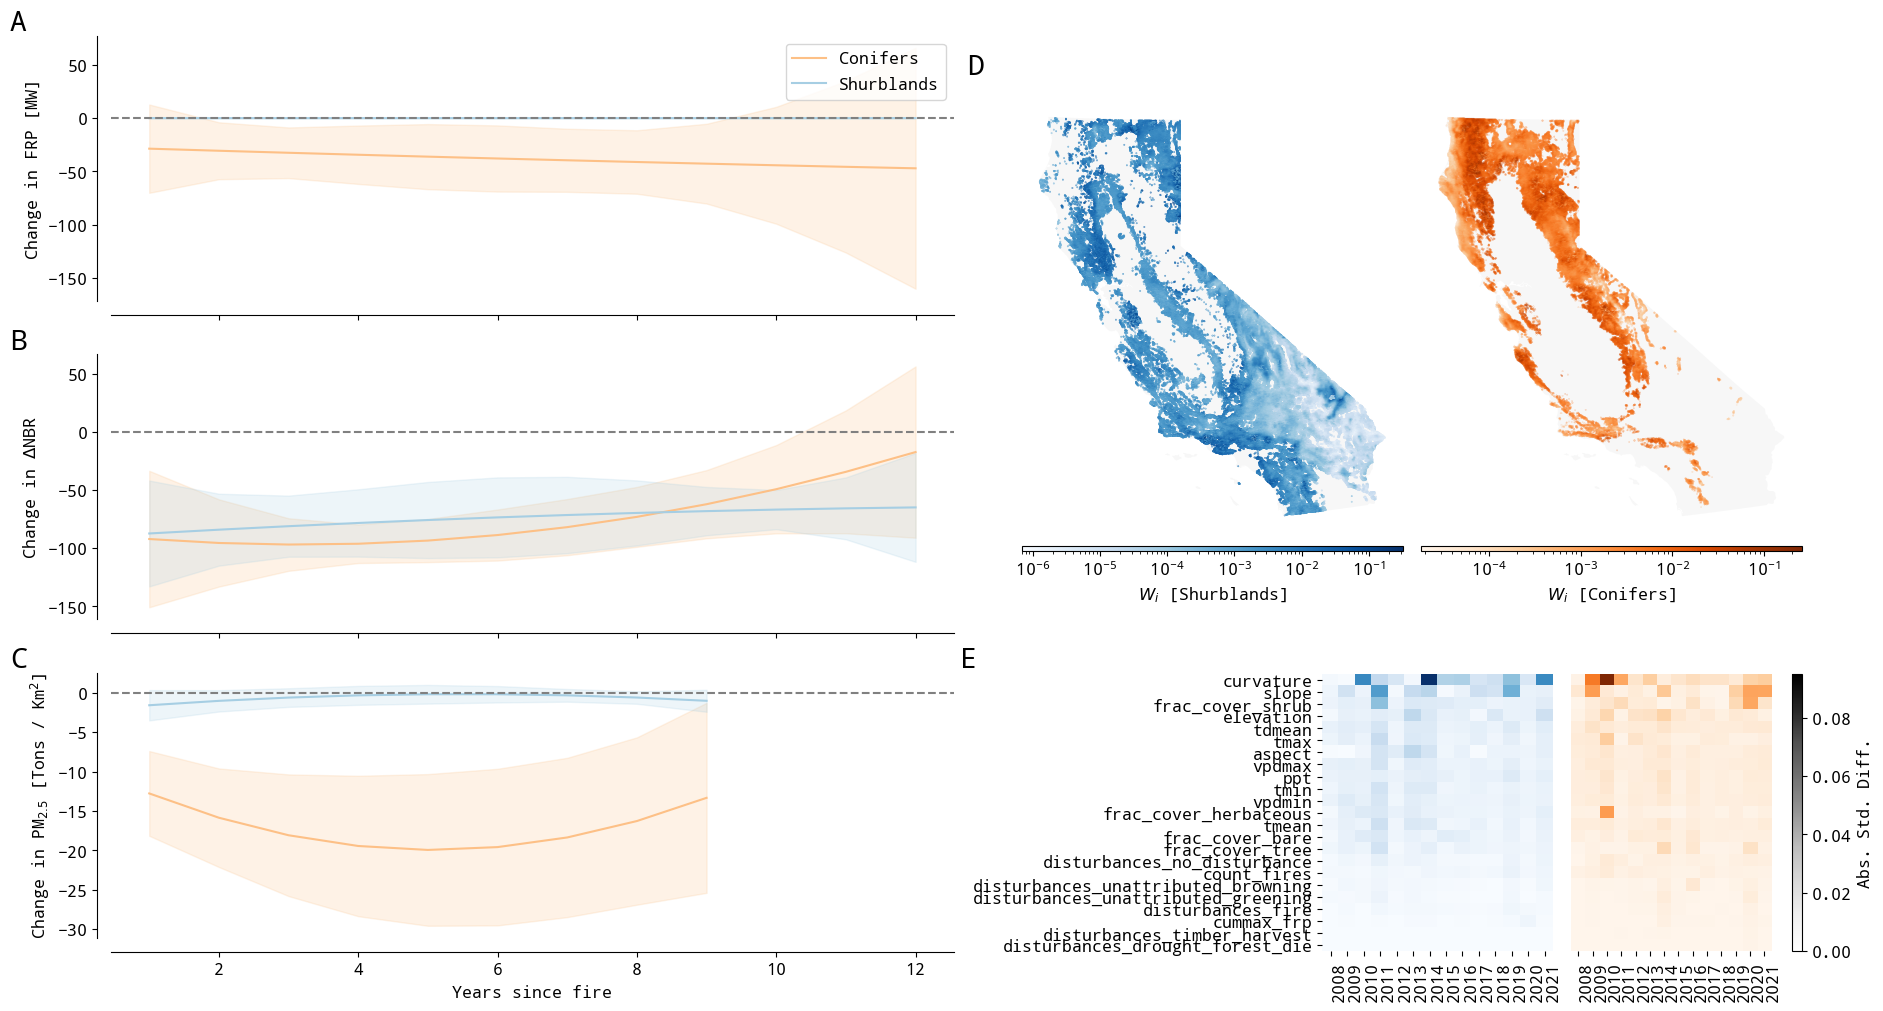

In [6]:
from matplotlib.gridspec import GridSpecFromSubplotSpec

plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(18, 10), layout="constrained")
spec = fig.add_gridspec(3, 2)

################################################################################
################################# PLOT RESULTS #################################
################################################################################
ax = fig.add_subplot(spec[0, 0])

plot_outcomes(
    df_conifer=df_frp,
    df_shrub=df_frp_shurbs,
    var_interest="att",
    axes_names=(
        "Change in FRP [MW]",
        "Years since fire",
    ),
    ax=ax,
    legend=True,
    lowess=False,
    order=2,
    pooled=pool_results,
    label="A",
)

ax = fig.add_subplot(spec[1, 0], sharex=ax)

plot_outcomes(
    df_conifer=df_dnbr,
    df_shrub=df_dnbr_shurbs,
    var_interest="att",
    axes_names=(
        r"Change in $\Delta$NBR",
        "Years since fire",
    ),
    ax=ax,
    lowess=False,
    order=2,
    pooled=pool_results,
    label="B",
)

ax = fig.add_subplot(spec[2, 0], sharex=ax)

plot_outcomes(
    df_conifer=df_emissions,
    df_shrub=df_emissions_shurbs,
    var_interest="att",
    axes_names=(
        r"Change in PM$_{2.5}$ [Tons / Km$^{2}$]",
        "Years since fire",
    ),
    ax=ax,
    order=2,
    lowess=False,
    colorbar=False,
    pooled=pool_results,
    label="C",
)

# Create a custom colorbar with a different colormap when plotting the focal year
# estimates

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=1.0)

# fig.colorbar(
#     ScalarMappable(norm=Normalize(2008, 2020), cmap="Greys"),
#     cax=cax,
#     orientation="horizontal",
#     label="Focal Year",
# )

################################################################################
############################### PLOT WEIGHTS SYNTH #############################
################################################################################

# Create a new grid specification for the subplots
plt.rcParams.update({"font.size": 12})
subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[0:-1, 1])

ax = fig.add_subplot(subspec[0, 0])
# annotate_axes(ax, "Weights here")

# Plot conifer weights
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Load conifers weights based on dnbr
weights = shrubs_loss["weights_dnbr"].merge(template, on="grid_id")
weights = weights.groupby(["grid_id", "lat", "lon"], as_index=False)["weights"].mean()

weights = gpd.GeoDataFrame(
    weights,
    geometry=gpd.points_from_xy(weights.lon, weights.lat),
    crs="EPSG:3310",
)

norm = norm = LogNorm(vmin=weights["weights"].min(), vmax=weights["weights"].max())

ca.plot(ax=ax, color="#d9d9d9", alpha=0.2)

weights.plot(
    ax=ax,
    cax=cax,
    column="weights",
    cmap="Blues",
    norm=norm,
    legend=True,
    legend_kwds={"label": r"$W_{i}$ [Shurblands]", "orientation": "horizontal"},
    markersize=0.1,
)
# Remove the axis labels and lines
template_plots(ax, no_axis=True, ylab="", xlab="", label="D")

ax = fig.add_subplot(subspec[0, 1])
# annotate_axes(ax, "Weights here")

# Plot shurbs weights
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Load conifers weights based on dnbr
weights = conifers_loss["weights_dnbr"].merge(template, on="grid_id")
weights = weights.groupby(["grid_id", "lat", "lon"], as_index=False)["weights"].mean()

weights = gpd.GeoDataFrame(
    weights,
    geometry=gpd.points_from_xy(weights.lon, weights.lat),
    crs="EPSG:3310",
)

norm = norm = LogNorm(vmin=weights["weights"].min(), vmax=weights["weights"].max())

ca.plot(ax=ax, color="#d9d9d9", alpha=0.2)

weights.plot(
    ax=ax,
    cax=cax,
    column="weights",
    cmap="Oranges",
    norm=norm,
    legend=True,
    legend_kwds={"label": r"$W_{i}$ [Conifers]", "orientation": "horizontal"},
    markersize=0.01,
)
# Remove the axis labels and lines
template_plots(ax, no_axis=True, ylab="", xlab="")

################################################################################
######################### PLOT STANDARIZED DIFFERENCES #########################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[2, 1], wspace=0.01)

# Define mins and max for the two plots
v_max = np.max(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
    ]
)

v_min = np.min(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
    ]
)

ax = fig.add_subplot(subspec[0, 0])
im1 = plot_std_diffs(
    std_diffs_df=shrubs_loss["std_diffs_dnbr"],
    palette="Blues",
    ax=ax,
    labels_y=True,
    draw_cbar=False,
    label="E",
    rotation_x=90,
    drop_vars=["Intercept", "land_type"],
)

ax = fig.add_subplot(subspec[0, 1])
im2 = plot_std_diffs(
    std_diffs_df=conifers_loss["std_diffs_dnbr"],
    palette="Oranges",
    labels_y=False,
    draw_cbar=False,
    rotation_x=90,
    drop_vars=["Intercept", "land_type"],
    ax=ax,
)

# Add a shared colorbar between the two plots im1 and im2
# Create a custom colorbar with a different colormap
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

fig.colorbar(
    ScalarMappable(norm=Normalize(vmin=v_min, vmax=v_max), cmap="Greys"),
    cax=cax,
    orientation="vertical",
    label="Abs. Std. Diff.",
)

# plt.subplots_adjust(wspace=0.01)
# plt.savefig(
#     f"../figs/fig_results_{dnbr_type}_{criteria}.png", bbox_inches="tight", dpi=300
# )

In [8]:
emissions_all = emissions_all.merge(land_type, on="grid_id")


<Axes: xlabel='year'>

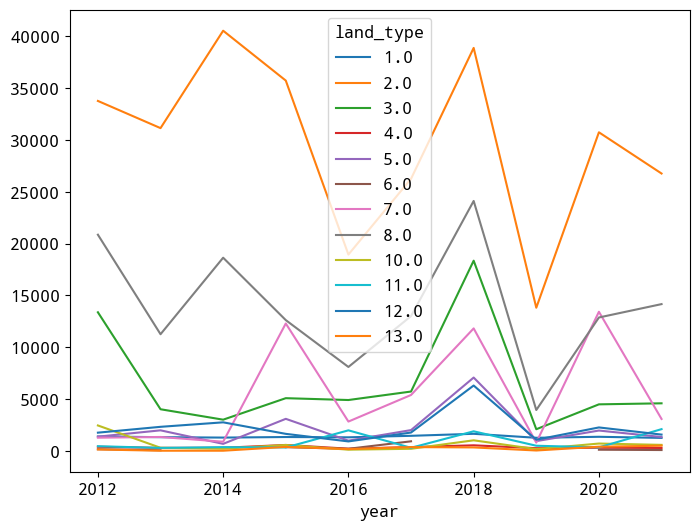

In [10]:
# Plot emissions grouped by land type and year
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

emissions_all.groupby(["year", "land_type"]).PM25.mean().unstack().plot(ax=ax)

In [21]:
emissions_all.groupby(["land_type"]).PM25.sum().sort_values(ascending=False)

land_type
2.0     1.352108e+09
8.0     5.291514e+07
12.0    4.806845e+07
3.0     4.547112e+07
1.0     4.094021e+07
5.0     8.876965e+06
7.0     7.819163e+06
4.0     8.586720e+05
10.0    5.217376e+05
11.0    3.182747e+05
13.0    5.278397e+04
6.0     6.568795e+03
Name: PM25, dtype: float64